#Задание 2

Предсказать стоимость домов

Сравнить алгоритмы линейной регресии с полным градиентным спуском и стохастическим градиентным спуском по MSE на тестовой выборке и времени работы алгоритма

##Решение

In [18]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.3, random_state=10)

In [19]:
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [20]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [21]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [22]:
X.shape, y.shape

((506, 13), (506,))

In [38]:
bos = pd.DataFrame(data['data'],columns = data['feature_names'])
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Построим график зависимости стоимости от криминогенной обстановки.


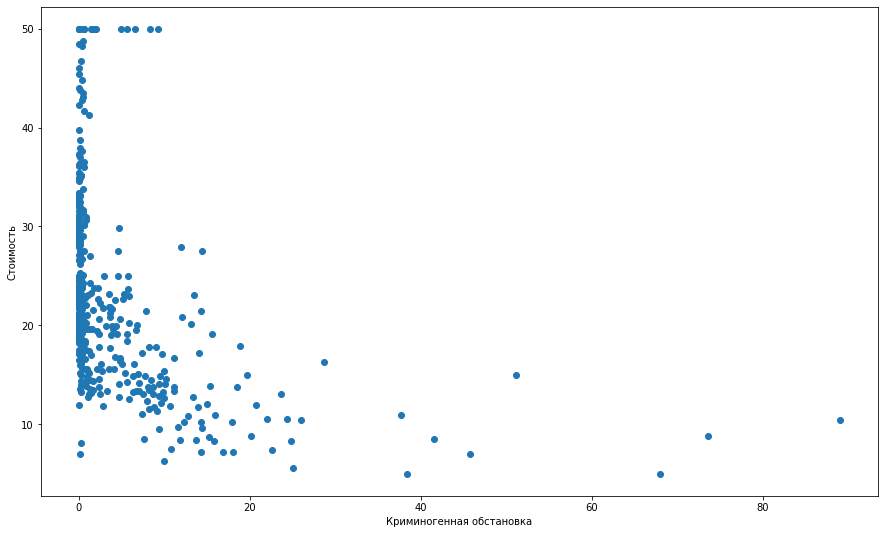

In [43]:

plt.scatter(X['CRIM'], y)
plt.xlabel('Криминогенная обстановка')
plt.ylabel('Стоимость')
plt.show()

Менее дорогие квартиры находятся в районах с высоким уровнем криминогенной обстановки.

Построим график зависимости стоимости от концентрации оксидов азота

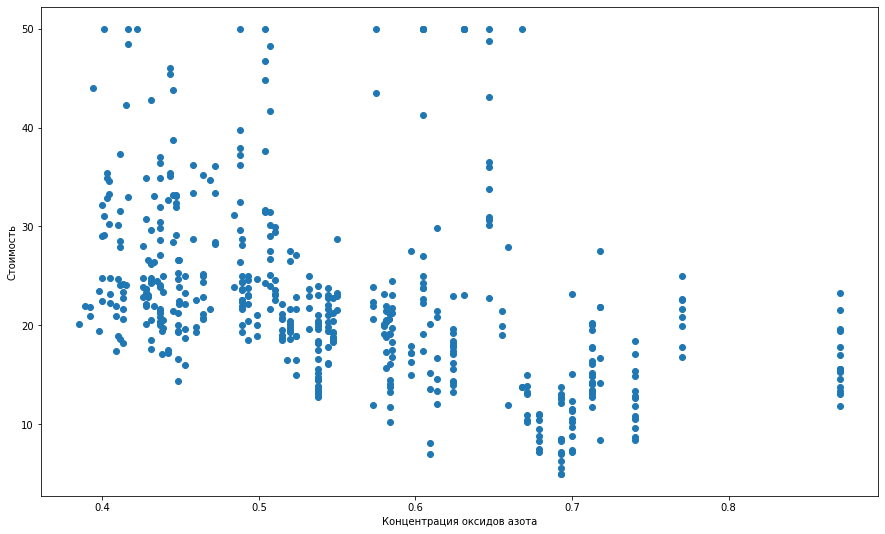

In [44]:
plt.scatter(X['NOX'], y)
plt.xlabel('Концентрация оксидов азота')
plt.ylabel('Стоимость')
plt.show()

Построим график зависимости стоимости от количества комнат.

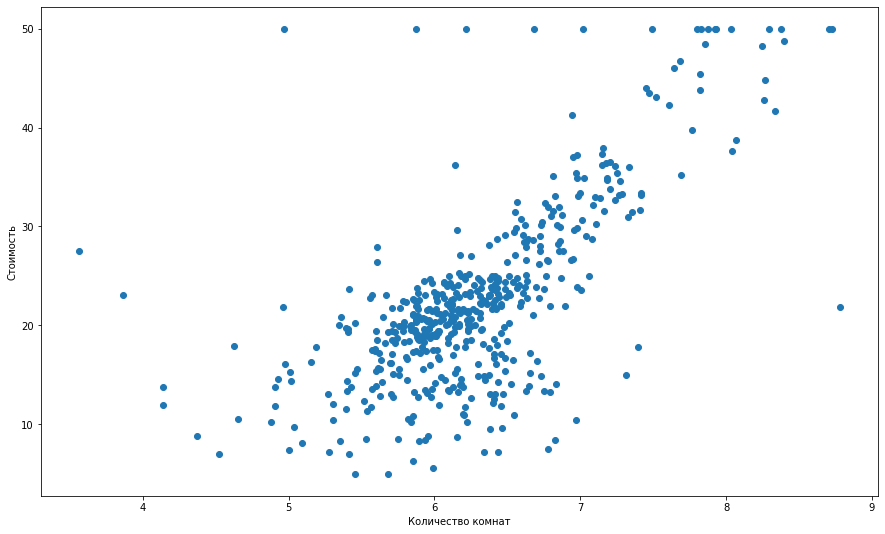

In [45]:
plt.scatter(X['RM'], y)
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость')
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsRegressor

In [25]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform')


In [26]:
knn.fit(X_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [27]:
predictions = knn.predict(X_test)


Нами были вычислены предсказания. Необходимо посчитать метрику MSE.

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

54.49207105263158

Алгоритм переберет все возможные комбинации, посчитает метрику для каждого набора и выдаст лучший набор.

In [29]:
from sklearn.model_selection import GridSearchCV
grid_searcher = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'n_neighbors': range(1, 40, 2),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    },
    cv=5
)

cv=5 - кросс-валидация с 5 фолдами

Вычислив метрики на итерациях, усредним их и получим оценку качества алгоритма.

In [30]:

%%time

grid_searcher.fit(X_train, y_train);

CPU times: user 3.56 s, sys: 13.3 ms, total: 3.57 s
Wall time: 3.57 s


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 40, 2), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
best_predictions = grid_searcher.predict(X_test)


In [32]:
mean_squared_error(y_test, best_predictions)


43.66135960354048

Давайте посмотрим на лучшие параметры из кросс-валидации.



In [33]:
grid_searcher.best_params_


{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Оценим качество с помощью кросс-валидации на обучающей выборке.

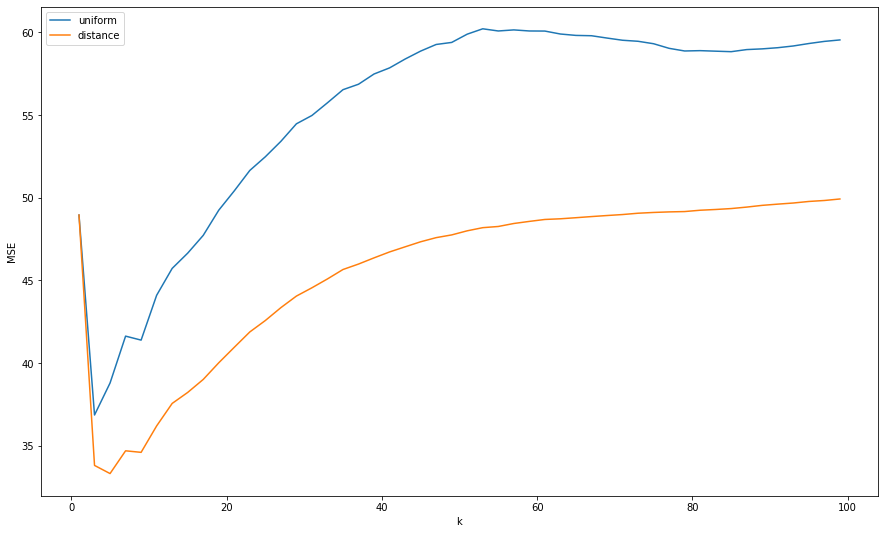

In [34]:
from sklearn.model_selection import cross_val_score

neighbors = np.arange(1, 101, 2)

scores_uni = []
scores_dis = []

for k in neighbors:
    knn_uniform = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn_distance = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores_uni.append(-cross_val_score(knn_uniform, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    scores_dis.append(-cross_val_score(knn_distance, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
plt.plot(neighbors, scores_uni, label='uniform')
plt.plot(neighbors, scores_dis, label='distance')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.show()